# Objective
The aim of this problem is to classify adults in two different groups based on their income where group 1 has an income less than USD 50k and group 2 has an income of more than or equal to USD 50k.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,classification_report

C:\Users\akash\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                'hours-per-week', 'native-country', 'income']

adult = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

### Explore the dataset

In [3]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult.shape

(32561, 15)

In [5]:
adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [6]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### EDA and Data Cleaning

In [7]:
adult.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [8]:
adult['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [9]:
adult['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [10]:
adult['sex'].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [11]:
adult.describe(exclude="object")

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
adult.describe(include="object")

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


### Display age statistics for each race (race feature) and each gender (sex feature). Use groupby() and describe(). Find the maximum age of men of Amer-Indian-Eskimo race.

In [13]:
adult.groupby(['race', 'sex'])['age'].describe()

count       mean        std   min   25%   50%  \
race               sex                                                       
Amer-Indian-Eskimo Female    119.0  37.117647  13.114991  17.0  27.0  36.0   
                   Male      192.0  37.208333  12.049563  17.0  28.0  35.0   
Asian-Pac-Islander Female    346.0  35.089595  12.300845  17.0  25.0  33.0   
                   Male      693.0  39.073593  12.883944  18.0  29.0  37.0   
Black              Female   1555.0  37.854019  12.637197  17.0  28.0  37.0   
                   Male     1569.0  37.682600  12.882612  17.0  27.0  36.0   
Other              Female    109.0  31.678899  11.631599  17.0  23.0  29.0   
                   Male      162.0  34.654321  11.355531  17.0  26.0  32.0   
White              Female   8642.0  36.811618  14.329093  17.0  25.0  35.0   
                   Male    19174.0  39.652498  13.436029  17.0  29.0  38.0   

                             75%   max  
race               sex                  
Amer-Indian-Eskimo Female  46.00  80.0  
                   Male    45.00  82.0  
Asian-Pac-Islander Female  43.75  75.0  
                   Male    46.00  90.0  
Black              Female  46.00  90.0  
                   Male    46.00  90.0  
Other              Female  39.00  74.0  
                   Male    42.00  77.0  
White              Female  46.00  90.0  
                   Male    49.00  90.0

In [14]:
adult.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income                2
dtype: int64

In [15]:
adult.duplicated().sum()

24

In [16]:
adult.drop_duplicates(inplace=True)

In [17]:
adult.isin(["?"]).any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
income            False
dtype: bool

In [18]:
adult.isin(["?"]).sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64

In [19]:
for column in adult.columns:
    # Calculate the most frequent category (mode)
    most_frequent_category = adult[column].mode()[0]
    
    # Replace missing values with the most frequent category
    adult[column] = adult[column].replace(['?', 'NAN', 'other_missing_value'], most_frequent_category)

In [20]:
adult.groupby(['education'])['education'].count()

education
10th              933
11th             1175
12th              433
1st-4th           166
5th-6th           332
7th-8th           645
9th               514
Assoc-acdm       1067
Assoc-voc        1382
Bachelors        5353
Doctorate         413
HS-grad         10494
Masters          1722
Preschool          50
Prof-school       576
Some-college     7282
Name: education, dtype: int64

### Let's make the categorical variable "class" a numeric variable. For this, let's assign values 1 for incomes greater than 50K and 0 for incomes less than 50K.

In [21]:
#convert <=50K and >50K to 0, 1 respectively
encoder=LabelEncoder()
adult['income']=encoder.fit_transform(adult['income'])

### Correlation Analysis

#### Correlation heatmap for numerical variables.

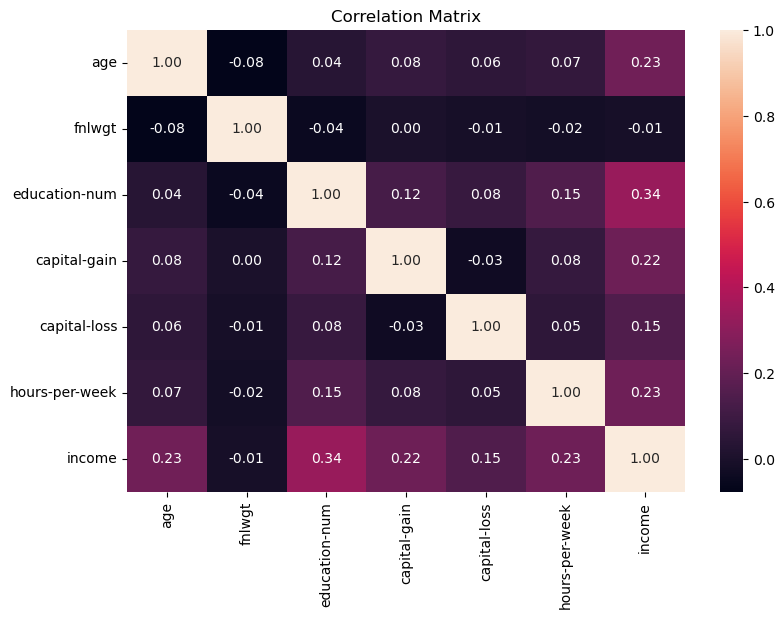

In [22]:
# Calculate the correlation matrix
correlation_matrix = adult.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- Income is highly positive corerelated with each variable.
- Age is high positively correlated with income(0.23),and moderately with capital gain (0.08), indicating older people tend to have higher income and capital gains.
- Education-num is moderately positively correlated with capital gain (0.12) and hours worked per week (0.15),suggesting more educated people earn more capital gains and work more hours.
- Hours worked per week is
- positively correlated with education (0.15) and capital gain (0.08), implying people who work more hours tend to be more educated and earn more capital gains.
- Fnlwgt (final weight) seems weakly correlated with other features, suggesting it provides unique information.

###  Identifying Outliers:
1. Use descriptive statistics (such as the interquartile range, IQR) to identify outliers. 
2. Statistical tests can also be used, such as the Z-score.
3. Visualizations like box plots can help in identifying outliers.

In [23]:
num_col = (['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [24]:
# Function to detect outliers using Z-Score
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    return (z_scores > threshold).all(axis=1)

outliers_zscore = detect_outliers_zscore(adult[num_col])

print("Outliers detected by Z-Score method:")
adult[outliers_zscore].shape

Outliers detected by Z-Score method:


(0, 15)

#### Insights
- no outliers were detected in the specified columns based on the Z-Score method with the threshold value of 3.

- The Z-Score method identifies outliers by measuring how many standard deviations a data point is from the mean. 

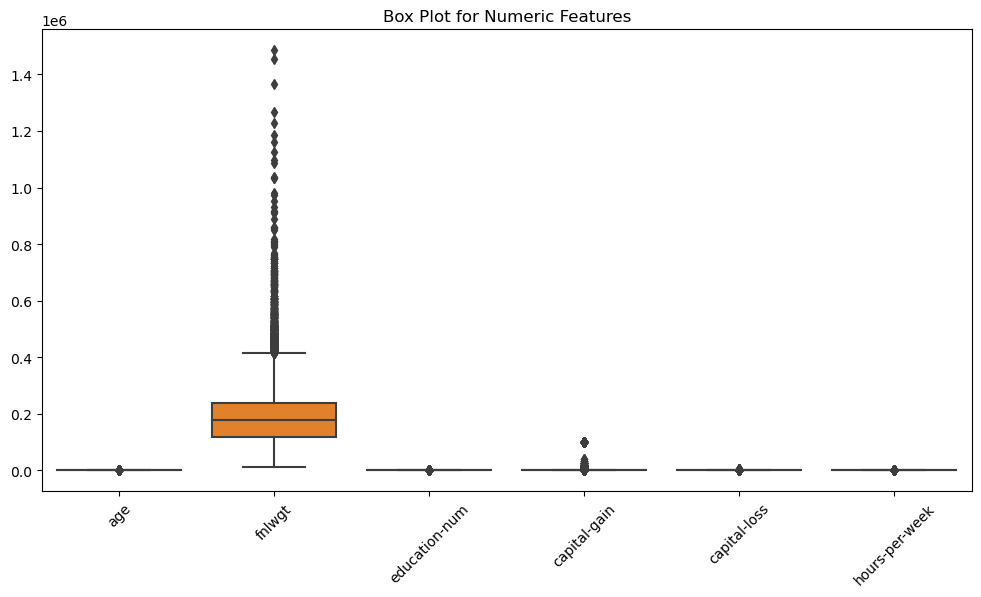

In [25]:
# Detect outliers using box plot visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=adult[num_col])
plt.title("Box Plot for Numeric Features")
plt.xticks(rotation=45)
plt.show()

### Treating Outliers:
    
1. Removing Outliers: You can simply remove the rows containing outliers.

2. Transforming Outliers: Apply transformations like log and Winsorizing transformation to reduce the impact of outliers.

In [26]:
# Apply log transformation to specific columns with outliers
columns_to_transform = ['capital-gain', 'fnlwgt']
adult[columns_to_transform] = adult[columns_to_transform].apply(lambda x: np.log(x + 1))

# Print the transformed data
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,11.258253,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0,40,United-States,0
1,50,Self-emp-not-inc,11.330348,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0,13,United-States,0
2,38,Private,12.281398,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0,40,United-States,0
3,53,Private,12.366157,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0,40,United-States,0
4,28,Private,12.732013,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0,40,Cuba,0


### Data Visualisation 

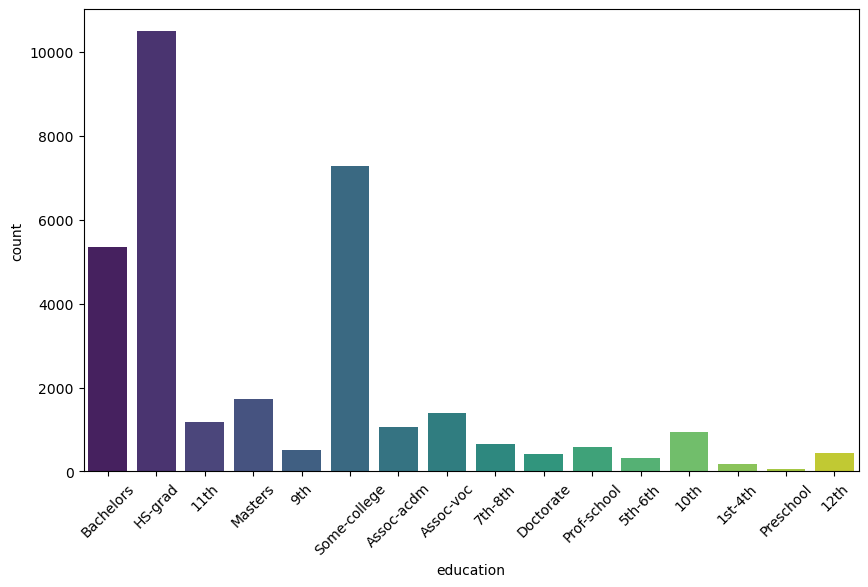

In [27]:
# Plot bar chart for 'education' variable
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=adult, palette='viridis')
plt.xticks(rotation=45)
plt.show()

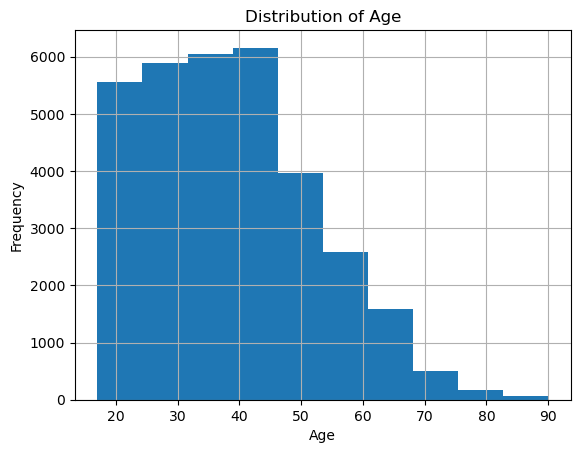

In [28]:
adult['age'].hist()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

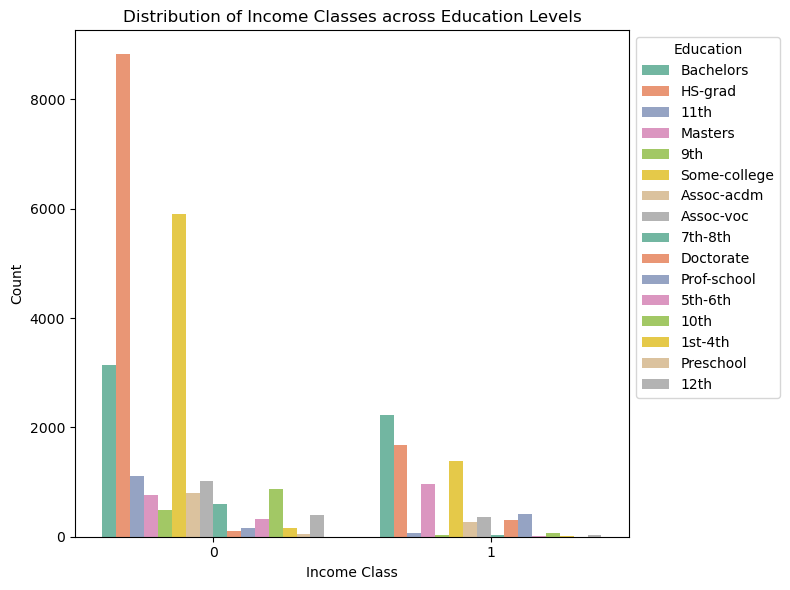

In [29]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a count plot for the target variable 'class' across different categories
sns.countplot(x='income', hue='education', data=adult, palette='Set2')

# Set plot labels and title
plt.xlabel('Income Class')
plt.ylabel('Count')
plt.title('Distribution of Income Classes across Education Levels')

# Show the plot
plt.legend(title='Education',bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [30]:
def bar_plot(variable):
    # we get the features
    var = adult[variable]
    # count number of categorical variable
    varValue = var.value_counts()
    
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

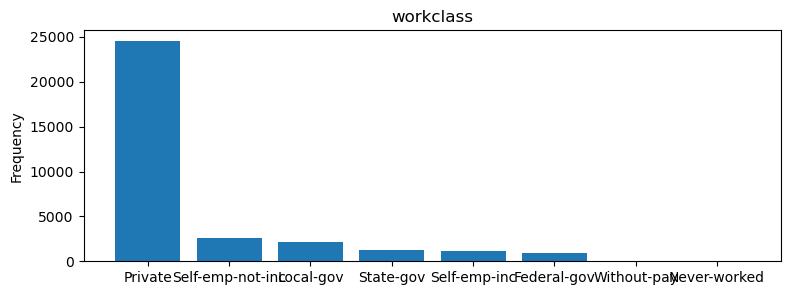

workclass: 
 Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


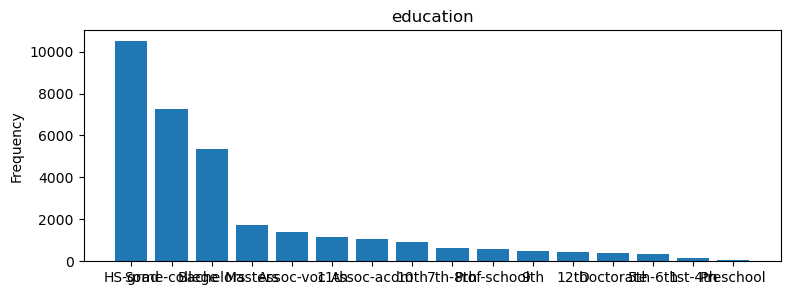

education: 
 HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: education, dtype: int64


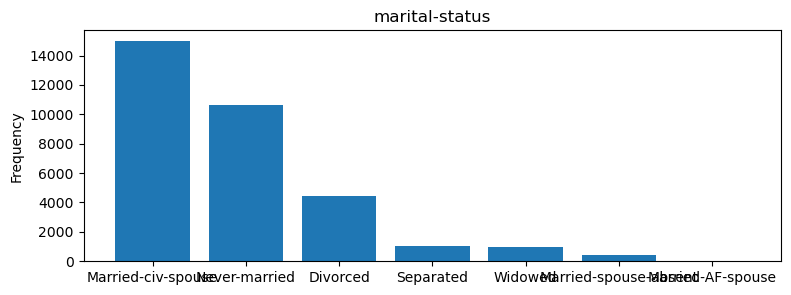

marital-status: 
 Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64


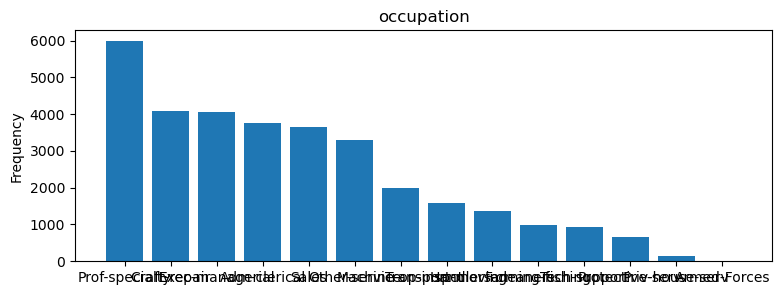

occupation: 
 Prof-specialty       5979
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64


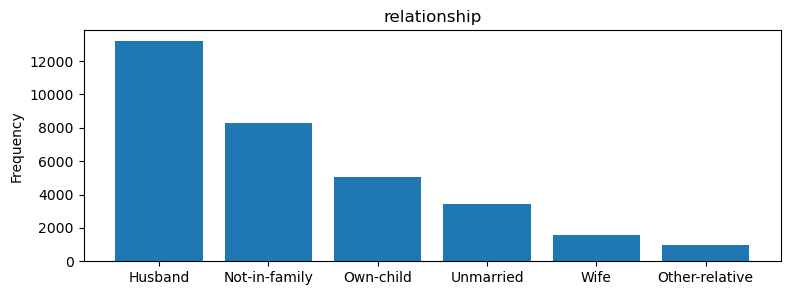

relationship: 
 Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


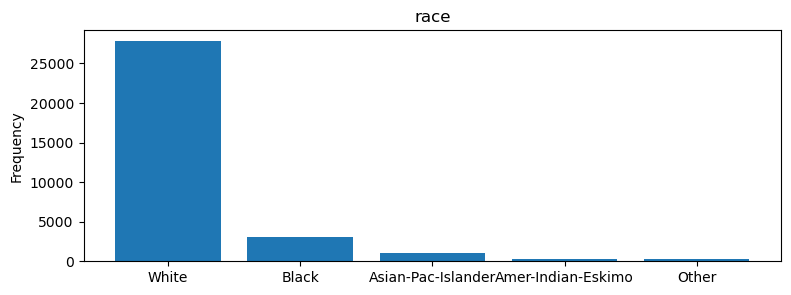

race: 
 White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


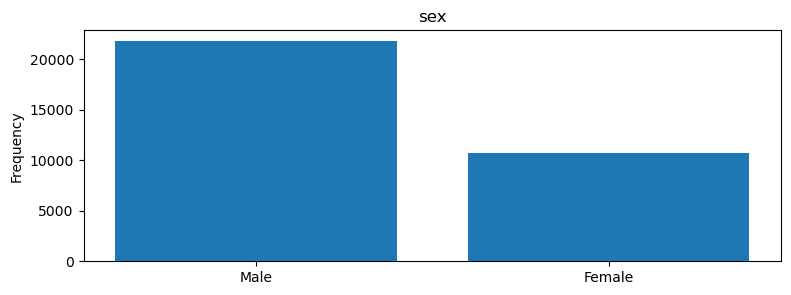

sex: 
 Male      21775
Female    10762
Name: sex, dtype: int64


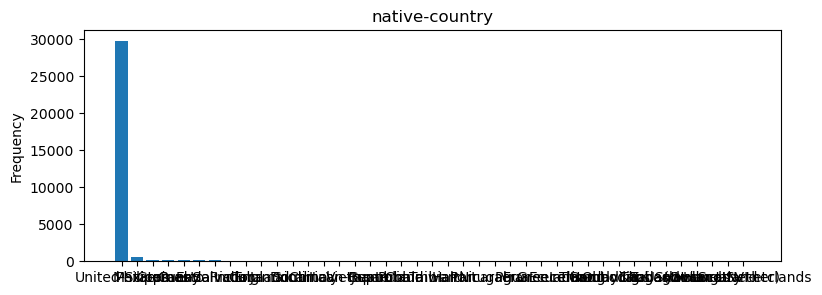

native-country: 
 United-States                 29735
Mexico                          639
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece    

In [31]:
categorical_var = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex","native-country"]
for each in categorical_var:
    bar_plot(each)

### Data Distribution:

- Skewness indicates the asymmetry of the data distribution. 
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. 
- If the skewness is less than -1 or greater than 1, the data are highly skewed.

In [32]:
# Select numerical columns
numerical_columns = adult.select_dtypes(include=['number'])

# Calculate skewness for each numerical column
skewness = numerical_columns.apply(lambda x: skew(x.dropna()))

# Create a DataFrame to store column names and their skewness values
skewness_df = pd.DataFrame({'Feature': skewness.index, 'Skewness': skewness.values})

# Print skewness values for each column
print(skewness_df)


          Feature  Skewness
0             age  0.557637
1          fnlwgt -0.842165
2   education-num -0.309486
3    capital-gain  3.094524
4    capital-loss  4.592491
5  hours-per-week  0.228748
6          income  1.211632


### Bivariate Analysis:

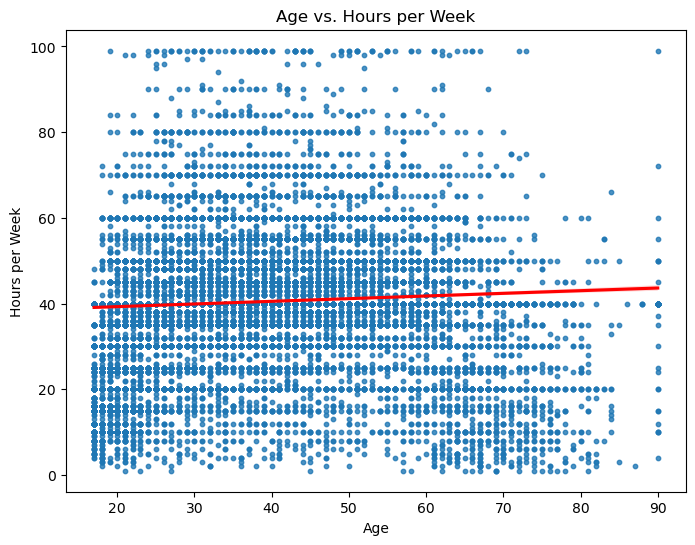

In [33]:
# Scatter plot with regression line for 'age' vs. 'hours-per-week'
plt.figure(figsize=(8, 6))
sns.regplot(x='age', y='hours-per-week', data=adult, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Age')
plt.ylabel('Hours per Week')
plt.title('Age vs. Hours per Week')
plt.show()

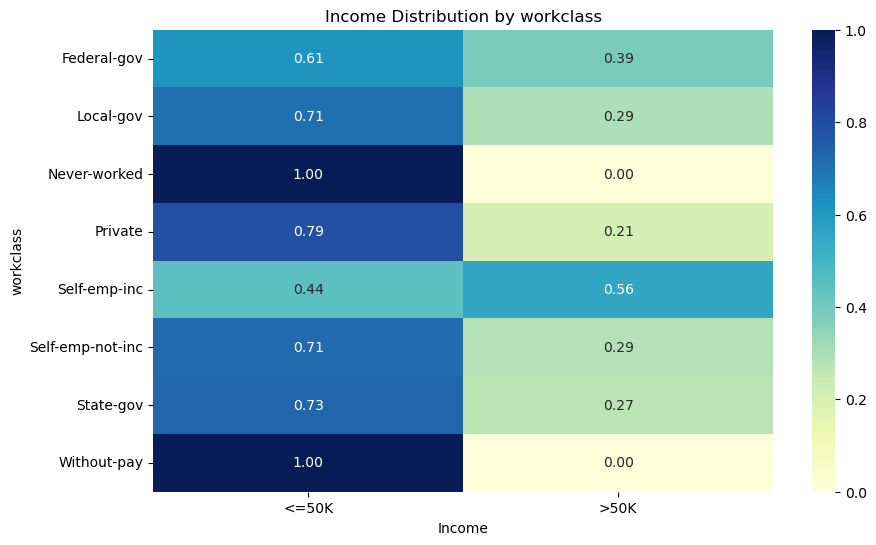

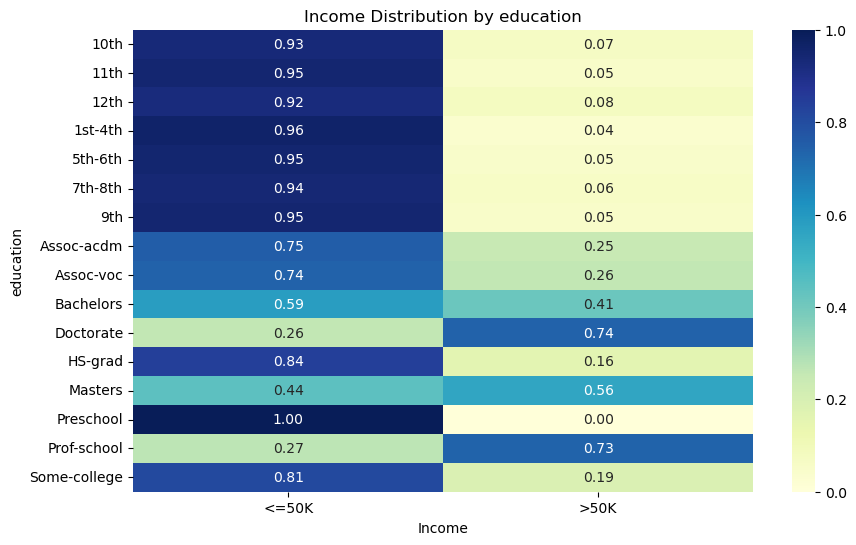

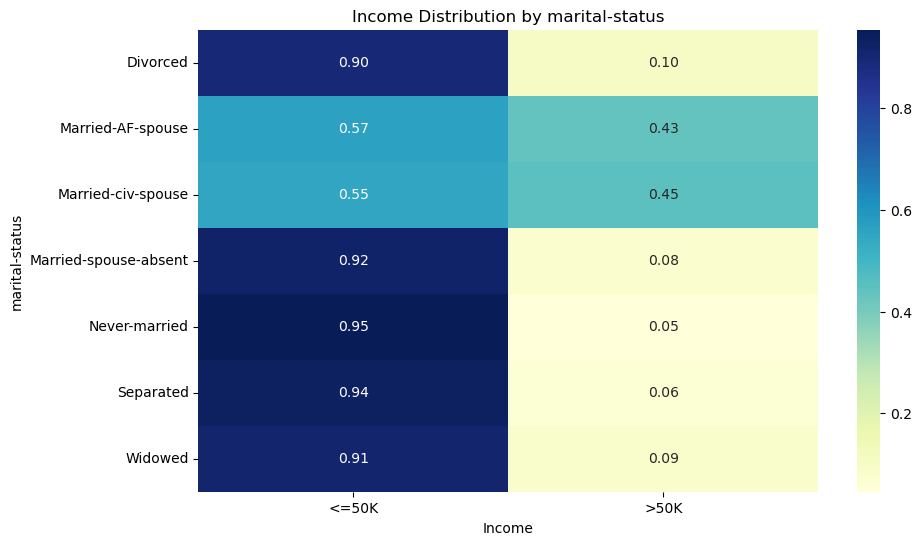

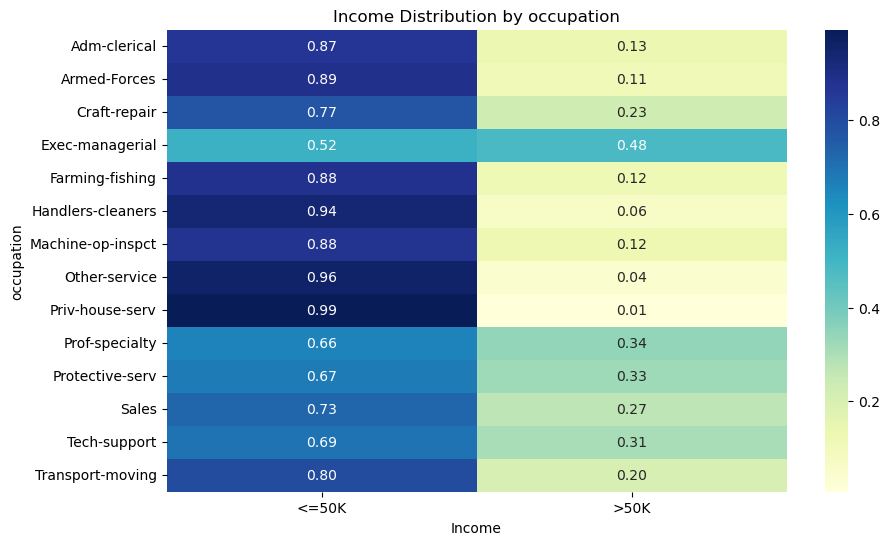

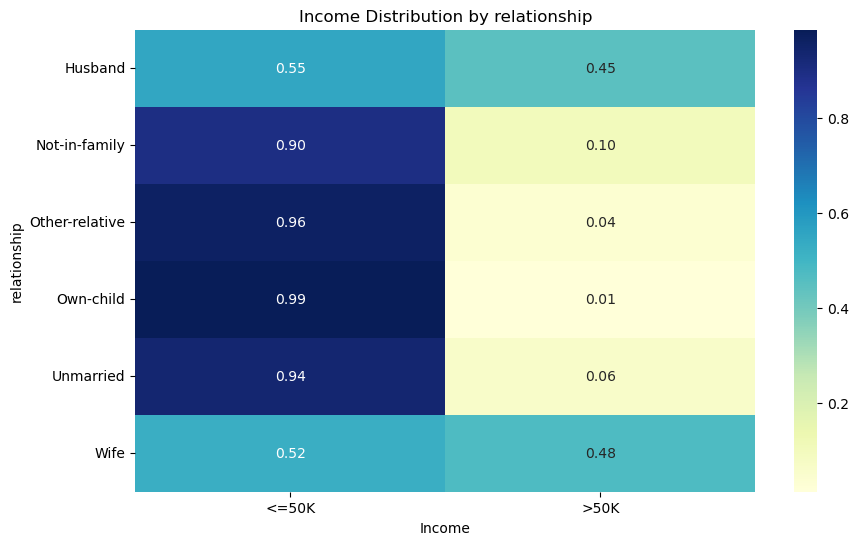

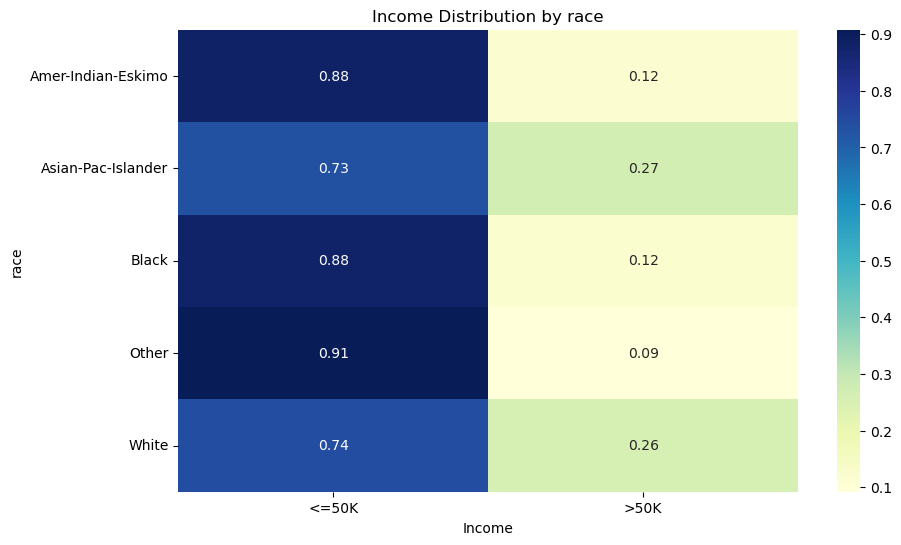

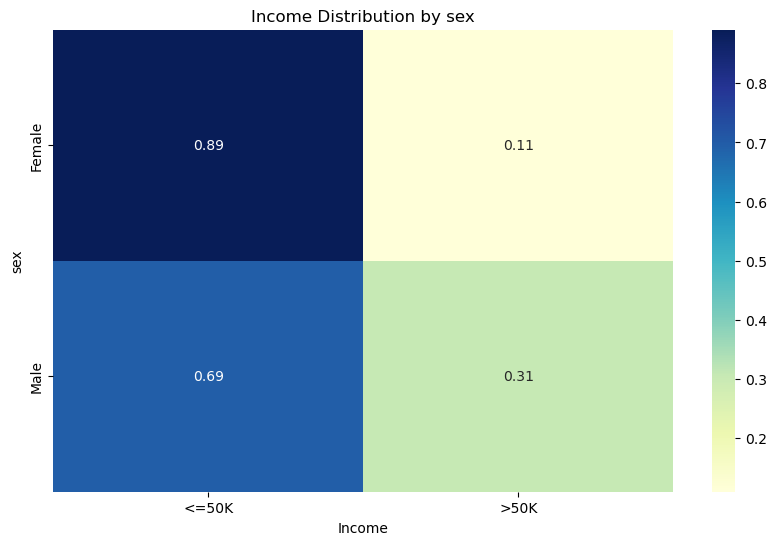

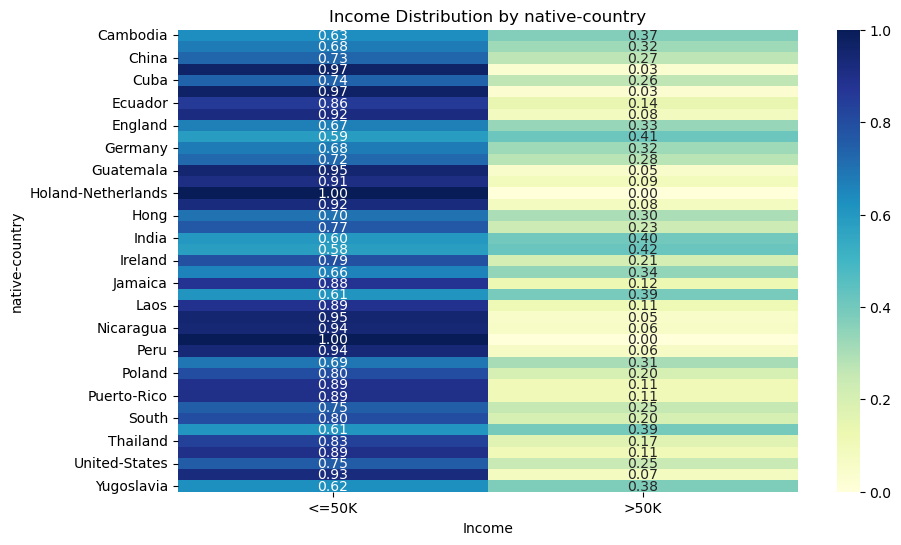

In [34]:
# Bivariate analysis for categorical variables using a heatmap
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.crosstab(adult[var], adult['income'], normalize='index'), annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f'Income Distribution by {var}')
    plt.xlabel('Income')
    plt.ylabel(var)
    plt.xticks(ticks=[0.5, 1.5], labels=['<=50K', '>50K'], rotation=0)
    plt.show()

### Encoding Categorical Variables

In [35]:
# Perform label encoding for categorical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country','income']

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    adult[column] = label_encoders[column].fit_transform(adult[column])

### Feature Scaling

In [36]:
# Perform feature scaling using StandardScaler
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

scaler = StandardScaler()
adult[numerical_columns] = scaler.fit_transform(adult[numerical_columns])

### Data Splitting

In [37]:
# 'X' contains features and 'y' contains the target variable
X = adult.drop('income', axis=1)  # Features
y = adult['income']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Model: {name}')
    
    # Generate and print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    print('\n' + '-'*40 + '\n')

Model: Logistic Regression
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      4905
           1       0.69      0.47      0.56      1603

    accuracy                           0.82      6508
   macro avg       0.77      0.70      0.72      6508
weighted avg       0.81      0.82      0.80      6508


----------------------------------------

Model: Decision Tree
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      4905
           1       0.60      0.63      0.61      1603

    accuracy                           0.81      6508
   macro avg       0.74      0.75      0.74      6508
weighted avg       0.81      0.81      0.81      6508


----------------------------------------

Model: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4905
          

#### INSIGHTS:
- Based on the evaluation results, Gradient Boosting model has the highest accuracy and a relatively balanced performance in terms of precision, recall, and F1 score. 